## Original input net version with eligibility and policy errors

In [17]:
from hrr import *
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [18]:
maze_size = 20 # Number of points
goal = [3,13] # Place the session ends
reward_bad = -1 # Reward for normal tiles
reward_goal = 0 # Reward for goal tiles

action_set = ["left", "right"] # Available actions the agent can take
gate_action_set = ["open", "close"]

color_set = ["red", "green"]

hrr_size = 1024 # Dimensionality of the HRRs (minimum 10x maze_size)

policy_gamma = 0.9 # Delayed reward coefficient 
policy_alpha = 0.001 # Learning rate
policy_epsilon = 0.03 # Random action chance
policy_lambda = 0.1 # 

input_epsilon = 0.7

epochs = 5000 
max_moves = maze_size

bias = 0.0 # Bias input for the agent 
eligibility = np.zeros([1,1,hrr_size]) 
input_eligibility = np.zeros([1,1,hrr_size])
targets = np.zeros([1,1,1]) # Q-Factored Qt values
input_targets = targets

choice_function = np.mean 

n_strats = 1

print(eligibility)

[[[0. 0. 0. ... 0. 0. 0.]]]


In [19]:
hidden_size = 32 # Number of nodes in hidden layers
input_layer = tf.keras.layers.Input(shape=[1,hrr_size]) # Defined input layer for HRR

# First hidden layer - nonlinear
hidden_layer = tf.keras.layers.Dense(hidden_size, activation='relu', use_bias=False)(input_layer)
# Second hidden layer - nonlinear
hidden_layer = tf.keras.layers.Dense(hidden_size, activation='relu', use_bias=False)(hidden_layer)

output_layer = tf.keras.layers.Dense(1, use_bias=False)(hidden_layer)

#c_layer = output_layer
#output_layer = tf.keras.layers.Reshape((1,1))(c_layer) # Shouldn't need due to only 1 strat

model = tf.keras.models.Model([input_layer],[output_layer])

model.compile(loss=tf.keras.losses.mse,
             optimizer=tf.keras.optimizers.SGD(learning_rate=policy_alpha))
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1, 1024)]         0         
_________________________________________________________________
dense_10 (Dense)             (None, 1, 32)             32768     
_________________________________________________________________
dense_11 (Dense)             (None, 1, 32)             1024      
_________________________________________________________________
dense_12 (Dense)             (None, 1, 1)              32        
Total params: 33,824
Trainable params: 33,824
Non-trainable params: 0
_________________________________________________________________


In [20]:
hidden_size = 8 # Number of nodes in hidden layers
input_layer = tf.keras.layers.Input(shape=[1,hrr_size]) # Defined input layer for HRR

# First hidden layer - nonlinear
hidden_layer = tf.keras.layers.Dense(hidden_size, activation='relu', use_bias=False)(input_layer)

output_layer = tf.keras.layers.Dense(1, use_bias=False)(hidden_layer)

#c_layer = output_layer
#output_layer = tf.keras.layers.Reshape((1,1))(c_layer) # Shouldn't need due to only 1 strat

input_model = tf.keras.models.Model([input_layer],[output_layer])

input_model.compile(loss=tf.keras.losses.mse,
             optimizer=tf.keras.optimizers.SGD(learning_rate=policy_alpha))
input_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1, 1024)]         0         
_________________________________________________________________
dense_13 (Dense)             (None, 1, 8)              8192      
_________________________________________________________________
dense_14 (Dense)             (None, 1, 1)              8         
Total params: 8,200
Trainable params: 8,200
Non-trainable params: 0
_________________________________________________________________


In [21]:
ltm = LTM(N=hrr_size, normalized=True, M=1)

suboptimal_steps = [] # performance tracker for 

In [22]:

def selection_function(action_votes):
    (x,y) = np.unique(action_votes, return_counts=True)
    return x[y.argmax()]

def logmod(x):
    return np.sign(x)*np.log(np.abs(x)+1.0)

def encode(state, action, signal, wm="I"):
    comp = "state"+str(state)+"*"+str(action)+"*"+str(signal) + "*"+"wm_"+str(wm)
    return np.array([ltm.encode(comp)])

def maxq(model, state, signal, wm, action_set):
    hrr = np.vstack([encode(state, action, signal) for action in action_set])
    hrr_wm = np.vstack([encode(state, action, signal, wm) for action in action_set])
    hrrs = np.vstack([hrr, hrr_wm])
    values = model.predict(hrrs)+bias
    max_actions = values.argmax(0)
    action = max_actions[values.argmax()%n_strats][0]
    return [np.hstack([values[max_actions[x],x:x+1,:] for x in range(n_strats)]),
            hrrs[action:action+1,:,:],
            action_set[action%len(action_set)]]

def greedyq(model, state, signal, wm, action_set):
    hrr = np.vstack([encode(state, action, signal) for action in action_set])
    hrr_wm = np.vstack([encode(state, action, signal, wm) for action in action_set])
    hrrs = np.vstack([hrr, hrr_wm])
    
    values = model.predict(hrrs)+bias
    max_actions = values.argmax(0)
    action = max_actions[values.argmax()%n_strats][0]
    return [values[action:action+1,:,:],
            hrrs[action:action+1,:,:],
            action_set[action%len(action_set)],
            wm]

def randomgreedyq(model, state, action_set):
    hrr = np.vstack([encode(state, action_set[0]), encode(state, action_set[1])])
    values = model.predict(hrr)+bias
    max_actions = values.argmax(0)
    action = max_actions[np.random.choice(n_strats)][0]
    return [values[action:action+1,:,:],
            hrr[action:action+1,:,:],
            action_set[action]]

def randomq(model, state, signal, wm, action_set, eligibility):
    eligibility[:,:,:] = 0.0
    action = np.random.choice(action_set)
    hrr = encode(state, action, signal)
    value = model.predict(hrr)+bias
    return [value,
            hrr,
            action,
            wm]

In [23]:


for epoch in range(epochs):
    eligibility[:,:,:] = 0
    input_eligibility[:,:,:] = 0
    current_state = np.random.choice(range(maze_size))
    goal_idx = np.random.choice(range(len(color_set)))
    optimal_steps = min((current_state-goal[goal_idx])%maze_size,  (goal[goal_idx]-current_state)%maze_size)
    current_signal = color_set[goal_idx]
    
    current_wm = "I"
    
    if(epoch+1) % 10 == 0:
        print('\rEpisode:', (epoch+1), end='')
        
    for step in range(max_moves):
        
        if current_state == goal[goal_idx]:
            break
        
        if np.random.random() < policy_epsilon:
            [current_input_value, _, current_input_action, _] = randomq(input_model, current_state, current_signal, current_wm, gate_action_set, input_eligibility)
        else:
            [current_input_value, _, current_input_action, _] = greedyq(input_model, current_state, current_signal, current_wm, gate_action_set)
            
        
        if np.random.random() < policy_epsilon:
            [current_value, current_hrr, current_action, current_wm] = randomq(model, current_state, current_signal, current_wm, action_set, eligibility)
        else:
            [current_value, current_hrr, current_action, current_wm] = greedyq(model, current_state, current_signal, current_wm, action_set)
            
        previous_value = current_value
        previous_hrr = current_hrr
        previous_wm = current_wm
        
        previous_input_value = current_input_value
        
        if current_input_action == "open":
            current_wm = current_signal
        
        if current_action == action_set[0]:
            current_state = (current_state-1)%maze_size
        else:
            current_state = (current_state+1)%maze_size
            
        if current_state == goal[goal_idx]:
            delta = reward_goal - previous_value
            target = logmod(delta) + previous_value
        else:
            [current_value,_,_] = maxq(model, current_state, current_signal, current_wm, action_set)
            delta = (reward_bad + (policy_gamma * current_value)) - previous_value
            target = logmod(delta) + previous_value
        
        if current_state == goal[goal_idx]:
            input_delta = reward_goal - previous_input_value
            input_target = logmod(input_delta) + previous_input_value
        else:
            [current_input_value,_,_] = maxq(input_model, current_state, current_signal, current_wm, gate_action_set)
            input_delta = (reward_bad + (policy_gamma * current_value)) - previous_value
            input_target = logmod(input_delta) + previous_input_value
            
        targets[:,:,:] = target
        input_targets[:,:,:] = input_target
        
        eligibility = (policy_lambda * eligibility) + previous_hrr
        input_eligibility = (policy_lambda * input_eligibility) + previous_hrr
        
        model.fit(eligibility, targets-bias, verbose=0)
        
        input_model.fit(input_eligibility, input_targets+bias, verbose=0)
        
        current_signal = "I"
        
    suboptimal_steps.append(step - optimal_steps)
            

Episode: 5000

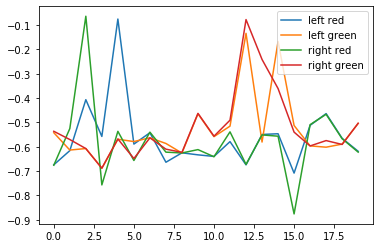

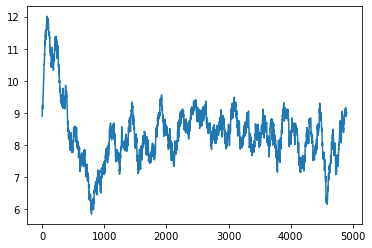

In [24]:
data = []
for action in action_set:
    for color in color_set:
        data += [choice_function(model.predict(encode(state, action, color))+bias) for state in range(maze_size)]
data = np.reshape(data, [4,maze_size]).T
plt.plot(data)
plt.legend(["left red", "left green", "right red", "right green"])
plt.show()

window_size = 100
data = [np.mean(suboptimal_steps[x:x+window_size]) for x in range(len(suboptimal_steps)-window_size)]
plt.plot(data)
plt.show()